In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [58]:
##GEORGIA GA
##PC:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Yearly data/Flats' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

##Bands and indices

df['Sensor'] = np.where(df['Year']<2013, 'Landsat 5', 'Landsat 8') ##make sure no other sensors are being used

df['ndvi'] = np.where(df['Sensor'] == 'Landsat 5', (df['B4']-df['B3'])/(df['B4']+df['B3']), \
                      (df['B5']-df['B4'])/(df['B5']+df['B4'])) ##ndvi conditional based on whether sensor is Landsat-5 or 8

df['Blue_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B1'], df['B2'])
df['Green_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B2'], df['B3'])
df['Red_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B3'], df['B4'])
df['NIR_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B4'], df['B5'])
df['SWIR1_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B5'], df['B6'])
df['SWIR2_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B7'], df['B7'])

df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

##DAYMET data added - yearly averages
##PC:
path2 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/GA/Yearly averages' 
all_files2 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files2:
    dm = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm)

dm = pd.concat(li, axis=0, ignore_index=True)

dm['ident'] = dm['Latitude']/dm['Longitude']

##Seasonal averages: growing season (defined as between 3/1 and 10/31)
path3 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/GA/Growing season' 
all_files3 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files3:
    dm2 = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm2)

dm2 = pd.concat(li, axis=0, ignore_index=True)

dm2['ident'] = dm2['Latitude']/dm2['Longitude']

dm2 = dm2.rename(columns={'dayl': 'sn_dayl', 'prcp': 'sn_prcp', 'srad': 'sn_srad', \
                        'tmax': 'sn_tmax','tmin': 'sn_tmin','vp': 'sn_vp'})

##Loading elevation data
elev_10m = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Point_elevation/DEM_vals_10m.csv')

elev_10m.rename(columns={'first':'Elevation'}, inplace=True)

## drop rows which have same lat and long and keep latest entry
dfx = elev_10m.drop_duplicates(
  subset = ['Latitude', 'Longitude'],
  keep = 'last').reset_index(drop = True)

dfx = dfx[['Elevation', 'Latitude', 'Longitude']]
dfx['ident'] = dfx['Latitude']/dfx['Longitude']

df['ident'] = df['Latitude']/df['Longitude'] 

##Merging elevation point data with band dataset prior to model development
df0 = pd.merge(df, dfx, on = 'ident')
df0_sn = pd.merge(df0, dm2)
df1 = pd.merge(df0_sn, dm)

df1 = df1[df1['ndvi'].notna()] ##remove rows with NaN for columns used in the model 
df1 = df1[df1['prcp'].notna()] ##CAREFUL; added 7/11/22
df1 = df1[df1['Species_Code'] == 'A1'] ##careful here
df1 = df1[(df1['flats'] < 0.1) & (df1['flats'] > -0.1)] ##Increases NRMSE by 0.003, but seems to be a better fit

ga_df1 = df1.copy()

from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics

xargs=df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation','prcp', 'dayl', 'tmax', 'tmin',
        'srad', 'vp', 'sn_prcp', 'sn_dayl','sn_tmax','sn_tmin','sn_srad','sn_vp'
    ]
]

yargs=df1['Plant_Biomass'] 

size_x = 0.2
seed = 0
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test - NOT NEEDED IN IMPLEMENTATION?
# # Pipeline example:
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

Mean Absolute Error: 256.54395394713157
Mean Squared Error: 151895.19235512972
Root Mean Squared Error: 389.7373376456633
The r squared is: 0.3200204902636987
testing r2 is: 0.3200204902636987
training r2 is: 0.9165816126574632
NRMSE is: 0.13067383878252728


In [59]:
##Virginia VA

##PC:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Yearly point extraction data' 
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df['Sensor'] = np.where(df['Year']<2013, 'Landsat 5', 'Landsat 8') 
df['ndvi'] = np.where(df['Sensor'] == 'Landsat 5', (df['B4']-df['B3'])/(df['B4']+df['B3']), \
                      (df['B5']-df['B4'])/(df['B5']+df['B4']))
df['Blue_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B1'], df['B2'])
df['Green_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B2'], df['B3'])
df['Red_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B3'], df['B4'])
df['NIR_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B4'], df['B5'])
df['SWIR1_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B5'], df['B6'])
df['SWIR2_band'] = np.where(df['Sensor'] == 'Landsat 5', df['B7'], df['B7'])
df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

df = df.drop(columns=['latitude','longitude'])
df['ident'] = df['Latitude'] / df['Longitude'] + df['Year'] 

##DAYMET data
path2 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/VA/Yearly averages' 
all_files2 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files2:
    dm = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm)

dm = pd.concat(li, axis=0, ignore_index=True)
dm.rename(columns={'site_id':'siteName'}, inplace=True)
dm = dm.drop(columns=['latitude','longitude'])
dm['ident'] = dm['Latitude'] / dm['Longitude'] + dm['Year']

##Seasonal averages: growing season (defined as between 3/1 and 10/31)
path3 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/VA/Growing season' 
all_files3 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files3:
    dm2 = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm2)

dm2 = pd.concat(li, axis=0, ignore_index=True)

dm2['ident'] = dm2['Latitude']/dm2['Longitude']

dm2 = dm2.rename(columns={'dayl': 'sn_dayl', 'prcp': 'sn_prcp', 'srad': 'sn_srad', \
                        'tmax': 'sn_tmax','tmin': 'sn_tmin','vp': 'sn_vp', 'swe': 'sn_swe'})

##TBD: Seasonal averages/growing season (defined as between 3/1 and 10/31)

##Loading elevation data
elev_10m = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Virginia/Point elevation/VA_DEM_vals_10m.csv')
elev_10m.rename(columns={'first':'Elevation'}, inplace=True)
elev_10m.rename(columns={'site_id':'siteName'}, inplace=True)
elev_10m['ident'] = elev_10m['Latitude'] / elev_10m['Longitude'] + elev_10m['Year']

##Merging daymet, elevation, and flats data
df['dropident'] = df['Latitude']/df['Longitude']*df['Year']+df['liveMass']
dm['dropident'] = dm['Latitude']/dm['Longitude']*dm['Year']+dm['liveMass']
dm2['dropident'] = dm2['Latitude']/dm2['Longitude']*dm2['Year']+dm2['liveMass']
elev_10m['dropident'] = elev_10m['Latitude']/elev_10m['Longitude']*elev_10m['Year']+elev_10m['liveMass']

dm0 = pd.merge(dm, dm2, on = ['dropident'], how = 'left')

dm0 = dm0.drop(dm0.loc[:, 'system:index_y':'ident_y'].columns, axis=1)

dm0.columns = [
    'dayl','prcp','srad','swe','tmax','tmin','vp','system:index','marshName','siteName', 'Latitude', 
    'Code', 'Longitude', 'monitoringPurpose', 'Replicate','Year', 'speciesName','locationID','liveMass','Transect','ident',
    'dropident', 'sn_dayl', 'sn_prcp', 'sn_srad', 'sn_swe', 'sn_tmax', 'sn_tmin', 'sn_vp'
]

##Merge daymet with remote sensing data:

df0 = pd.merge(df, dm0, on = ['dropident'], how = 'left')

df0['dropident'] = df0['Latitude_x']/df0['Longitude_x']*df0['Year_x']+df0['liveMass_x']
print(len(df0['dropident']))
df0 = df0.drop_duplicates(
  subset = ['dropident'],
  keep = 'last').reset_index(drop = True)
print(len(df0['dropident']))

##Merge with elevation
df1 = pd.merge(df0, elev_10m, on = ['dropident'], how = 'left')

df1['dropident'] = df1['Latitude_x']/df1['Longitude_x']*df1['Year_x']+df1['liveMass_x']
print(len(df1['dropident']))
df1 = df1.drop_duplicates(
  subset = ['dropident'],
  keep = 'last').reset_index(drop = True)
print(len(df1['dropident']))

##THIS NEEDS TO BE 0
print('df0 biomass diff is: '+str(sum(df0['liveMass_x'] - df0['liveMass_y'])))
print('df1 biomass diff (x-y) is: '+str(sum(df1['liveMass_x'] - df1['liveMass_y'])))
print('df1 biomass diff (x-z) is: '+str(sum(df1['liveMass_x'] - df1['liveMass'])))
# df1.rename(columns={'liveMass_x':'liveMass'}, inplace=True)

print("biomass measurements: " + str(len(df1['liveMass'])))
print(len(df1['Elevation'].unique()))

df1 = df1.drop(columns = ['latitude', 'longitude']) ##lower case ones are the older values

##Some more data massaging
df1 = df1[df1['ndvi'].notna()]
df1 = df1[df1['liveMass'].notna()]
df1 = df1[df1['Latitude'].notna()]
df1 = df1[(df1['flats'] < 0.1)] ##Double check

##Group df1 and average (midpoint) the replicates (a/b)
df_temp=df1.copy()

df_temp = df_temp.groupby(['Year','locationID','Transect','Latitude','Longitude'],as_index = False).aggregate(
    {
        'liveMass':[np.mean, np.size],'ndvi':[np.mean],'nd_swir2_r':[np.mean],'nd_swir2_nir':[np.mean],'nd_g_b':[np.mean],
        'nd_r_g':[np.mean],'wdrvi5':[np.mean],'savi':[np.mean],'Elevation':[np.mean],'prcp':[np.mean],'dayl':[np.mean],
        'tmax':[np.mean],'tmin':[np.mean],'srad':[np.mean],'vp':[np.mean], 'sn_prcp':[np.mean],'sn_dayl':[np.mean],
        'sn_tmax':[np.mean],'sn_tmin':[np.mean],'sn_srad':[np.mean],'sn_vp':[np.mean]
    }
)

df_temp.columns = [
    'Year','locationID','Transect','Latitude','Longitude','liveMass','N','ndvi','nd_swir2_r','nd_swir2_nir', 'nd_g_b', 
    'nd_r_g', 'wdrvi5', 'savi', 'Elevation','prcp', 'dayl','tmax','tmin','srad','vp','sn_prcp', 'sn_dayl','sn_tmax','sn_tmin',
    'sn_srad','sn_vp'
]

# display(df_temp)

##Machine learning
from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics

df1 = df_temp ##Therein the rub! COMMENT OUT if you do not want to group replicates
va_df1 = df_temp

print("biomass measurements: " + str(len(df1['liveMass'])))

xva=va_df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation','prcp', 'dayl', 'tmax', 'tmin',
        'srad', 'vp', 'sn_prcp', 'sn_dayl','sn_tmax','sn_tmin','sn_srad','sn_vp'
    ]
]

yva=va_df1['liveMass'] 

size_x = 0.2
seed = 3
xva_train, xva_test, yva_train, yva_test = train_test_split(xva, yva, test_size=size_x, random_state = seed) 
## 80% training and 20% test

VApipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
VApipe.fit(xva_train, yva_train)
va_pred=VApipe.predict(xva_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yva_test, va_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yva_test, va_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yva_test, va_pred)))
r_square = metrics.r2_score(yva_test, va_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(VApipe.score(xva_test, yva_test)))
print('training r2 is: ' + str(VApipe.score(xva_train, yva_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yva_test, va_pred))/np.ptp(yva_test)))

# Mean
print('MEAN BASELINE:')
va_pred_mean = [np.mean(yva_train)] * len(yva_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yva_test, va_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yva_test, va_pred_mean)))

1972
1846
1864
1846
df0 biomass diff is: 0.0
df1 biomass diff (x-y) is: 0.0
df1 biomass diff (x-z) is: 0.0
biomass measurements: 1846
153
biomass measurements: 611
Mean Absolute Error: 223.6267967324816
Mean Squared Error: 102170.66026562933
Root Mean Squared Error: 319.6414557995088
The r squared is: 0.19845108710317072
0.19845108710317072
testing r2 is: 0.19845108710317072
training r2 is: 0.8775705173767727
NRMSE is: 0.1256333741311782
MEAN BASELINE:
Mean Absolute Error: 271.943173752721
Root Mean Squared Error: 364.2745065572415


Mean Absolute Error: 612.1626999694492
Mean Squared Error: 500222.32354138547
Root Mean Squared Error: 707.2639701988116
The r squared is: -2.647257195494809
-2.647257195494809
NRMSE is: 0.27798634177546605


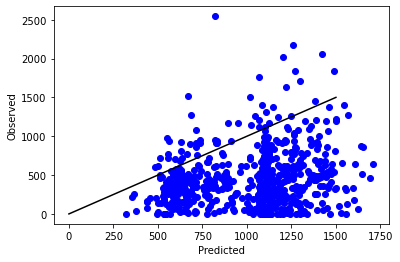

In [60]:
##Running the GA model on VA data

##Really, really needs improvement

va_xargs = va_df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation','prcp', 'dayl', 'tmax', 'tmin',
        'srad', 'vp', 'sn_prcp', 'sn_dayl','sn_tmax','sn_tmin','sn_srad','sn_vp'
    ]
]

va_yargs = va_df1['liveMass']

va_pred=pipe.predict(va_xargs)

print('Mean Absolute Error:', metrics.mean_absolute_error(va_yargs, va_pred))
print('Mean Squared Error:', metrics.mean_squared_error(va_yargs, va_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(va_yargs, va_pred)))
r_square = metrics.r2_score(va_yargs, va_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(va_yargs, va_pred))/np.ptp(va_yargs)))


plt.scatter(va_pred, va_yargs, color = 'blue')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 1500], [0, 1500], 'k-')
plt.show()

Mean Absolute Error: 352.8002430833991
Mean Squared Error: 296804.92636687943
Root Mean Squared Error: 544.7980601717295
The r squared is: 0.04577168731127079
0.04577168731127079
NRMSE is: 0.11535195602968704


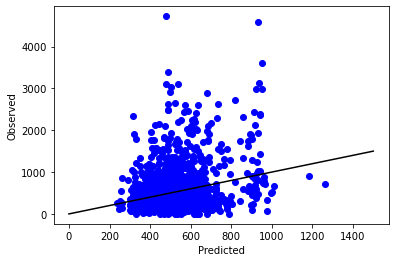

In [61]:
##Running the VA model on GA data

ga_xargs = ga_df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation','prcp', 'dayl', 'tmax', 'tmin',
        'srad', 'vp', 'sn_prcp', 'sn_dayl','sn_tmax','sn_tmin','sn_srad','sn_vp'
    ]
]

ga_yargs = ga_df1['Plant_Biomass']

ga_pred=VApipe.predict(ga_xargs)

print('Mean Absolute Error:', metrics.mean_absolute_error(ga_yargs, ga_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ga_yargs, ga_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ga_yargs, ga_pred)))
r_square = metrics.r2_score(ga_yargs, ga_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(ga_yargs, ga_pred))/np.ptp(ga_yargs)))


plt.scatter(ga_pred, ga_yargs, color = 'blue')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 1500], [0, 1500], 'k-')
plt.show()

,B1,B2,B3,B4,B5,B6,B7,flats,system:index,Site,...,dayl,prcp,srad,tmax,tmin,vp,lter,locationID,Transect,N
0,0.0271,0.0301,0.0309,0.0551,0.0357,0.2911,0.0289,0.019625,0.0,1.0,...,43200.085938,2.568438,342.593597,25.048056,14.132274,1776.901489,GA,NaN,NaN,NaN
1,0.0263,0.0404,0.0351,0.0745,0.0697,0.2883,0.0448,0.033653,0.0,1.0,...,43220.082031,2.596593,342.510712,25.575659,14.795082,1762.035522,GA,NaN,NaN,NaN
3,0.0344,0.0429,0.0374,0.0798,0.0649,0.2951,0.0362,0.095547,0.0,1.0,...,43200.085938,3.297945,340.148438,25.406548,14.338548,1778.461426,GA,NaN,NaN,NaN
4,0.0240,0.0361,0.0321,0.0872,0.0559,0.2947,0.0309,0.049471,0.0,1.0,...,43220.082031,4.259862,338.359924,25.079752,14.206429,1799.670776,GA,NaN,NaN,NaN
5,0.0598,0.0626,0.0610,0.1112,0.0979,0.2968,0.0613,0.004838,0.0,1.0,...,43220.082031,2.628269,351.314453,26.066071,14.187940,1683.812134,GA,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43225.171875,3.578928,307.891052,20.562885,11.365109,1535.228271,VA,3.0,A,2.0
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43224.957031,3.357912,308.119415,20.968325,11.728791,1573.322876,VA,3.0,B,2.0
608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43225.062500,3.305769,310.027924,20.746950,11.474368,1548.789673,VA,3.0,B,2.0
609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,43224.957031,3.342610,307.995300,21.011868,11.759917,1576.207886,VA,3.0,C,2.0


Mean Absolute Error: 315.87596610161233
Mean Squared Error: 303237.3381910955
Root Mean Squared Error: 550.6698994779863
The r squared is: 0.4412279120975231
0.4412279120975231
testing r2 is: 0.4412279120975231
training r2 is: 0.9055481836855614
NRMSE is: 0.1167379879600848
MEAN BASELINE:
Mean Absolute Error: 450.09745708933457
Root Mean Squared Error: 740.8303247705901


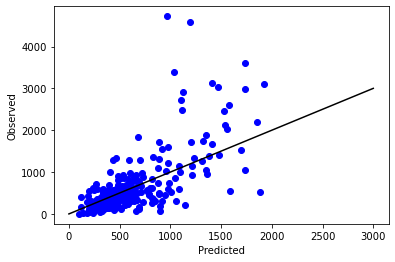

test data correlation coefficient is: 0.6885075387426549
train data correlation coefficient is: 0.9650565986247412


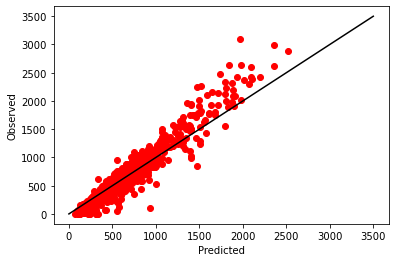

In [63]:
##Combining the datasets

ga_df1.rename(columns={'Plant_Biomass':'liveMass'}, inplace=True)

ga_df1['lter'] = 'GA'
va_df1['lter'] = 'VA'

combined_df = pd.concat([ga_df1, va_df1])

display(combined_df)

combined_df = combined_df[combined_df['ndvi'].notna()] ##remove rows with NaN for columns used in the model 
combined_df = combined_df[combined_df['prcp'].notna()] ##CAREFUL; added 7/11/22
combined_df = combined_df[combined_df['Species_Code'] == 'A1'] ##careful here

# from sklearn.model_selection import train_test_split
# from numpy import loadtxt
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score

xcomb=combined_df[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation','prcp', 'dayl', 'tmax', 'tmin',
        'srad', 'vp', 'sn_prcp', 'sn_dayl','sn_tmax','sn_tmin','sn_srad','sn_vp'
    ]
]

# ##From linear regression results: maybe remove nd_swir2_nir/r from feature list? May improve prediction results. 
# ##Also: nd_r_g, dayl, and vp all can be removed. Seasonal average vs. yearly average will probably be a choice.

# #'sn_prcp', 'sn_dayl', 'sn_tmax', 'sn_tmin', 'sn_srad', 'sn_vp'

# ##Include lag variables (e.g. lag ndvi), precip, temp, more

# ##ELEVATION NEEDS TO BE TRIPLE-CHECKED AT EACH PLOT TO MAKE SURE VALUES CORRESPOND

ycomb=combined_df['liveMass'] 

size_x = 0.2
seed = 8
xcomb_train, xcomb_test, ycomb_train, ycomb_test = train_test_split(xcomb, ycomb, test_size=size_x, random_state = seed) 
## 80% training and 20% test

# # Pipeline example:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipe_comb = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe_comb.fit(xcomb_train, ycomb_train)
comb_pred=pipe_comb.predict(xcomb_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(ycomb_test, comb_pred))
print('Mean Squared Error:', metrics.mean_squared_error(ycomb_test, comb_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ycomb_test, comb_pred)))
r_square = metrics.r2_score(ycomb_test, comb_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(pipe_comb.score(xcomb_test, ycomb_test)))
print('training r2 is: ' + str(pipe_comb.score(xcomb_train, ycomb_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(ycomb_test, comb_pred))/np.ptp(ycomb_test)))

# Mean
print('MEAN BASELINE:')
comb_pred_mean = [np.mean(ycomb_train)] * len(ycomb_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(ycomb_test, comb_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(ycomb_test,comb_pred_mean)))

plt.scatter(comb_pred, ycomb_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3000], [0, 3000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(ycomb_test, comb_pred)[0, 1]))

train_predcomb = pipe_comb.predict(xcomb_train) ##Not sure if this is the right thing to do here
plt.scatter(train_predcomb, ycomb_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3500], [0, 3500], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(train_predcomb, ycomb_train)[0, 1]))


In [36]:
##Comparing with standard empirical model -- just uncomment and run

##sklearn - linear_regressor L1 weights look at these

print(len(xcomb))
print(len(ycomb))

print(xcomb.head())

from sklearn import linear_model
import statsmodels.api as sm

regr = linear_model.LinearRegression()
regr.fit(xcomb, ycomb)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
xcomb = sm.add_constant(xcomb) ##adding a constant
 
model = sm.OLS(ycomb, xcomb).fit()
predictions = model.predict(xcomb) 
 
print_model = model.summary()
print(print_model) ##check model assumptions

1267
1267
   const      ndvi  nd_swir2_r  nd_swir2_nir    nd_g_b    nd_r_g    wdrvi5  \
0    1.0  0.281395   -0.033445     -0.311905  0.052448  0.013115 -0.057314   
1    1.0  0.359489    0.121402     -0.248952  0.211394 -0.070199  0.029717   
3    1.0  0.361775   -0.016304     -0.375862  0.109961 -0.068493  0.032342   
4    1.0  0.461861   -0.019048     -0.476715  0.201331 -0.058651  0.151915   
5    1.0  0.291521    0.002453     -0.289275  0.022876 -0.012945 -0.046312   

       savi  Elevation      prcp          dayl       tmax       tmin  \
0  0.061945   0.489376  2.568438  43200.085938  25.048056  14.132274   
1  0.096949   0.489376  2.596593  43220.082031  25.575659  14.795082   
3  0.103046   0.489376  3.297945  43200.085938  25.406548  14.338548   
4  0.133457   0.489376  4.259862  43220.082031  25.079752  14.206429   
5  0.112020   0.489376  2.628269  43220.082031  26.066071  14.187940   

         srad  swe           vp  
0  342.593597  0.0  1776.901489  
1  342.510712  0.0  

C:\ProgramData\Anaconda3\envs\venv\lib\site-packages\statsmodels\regression\linear_model.py:1917: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
